### **Importing Libraries**

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
data = pd.read_csv("/content/social media mental health data.csv", encoding='ISO-8859-1')
data.head()

,Sr.,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [8]:
data.shape

(53044, 3)

In [9]:
data.columns

Index(['Sr.', 'statement', 'status'], dtype='object')

In [10]:
data.dtypes

,0
Sr.,object
statement,object
status,object


### **Missing Values**

In [11]:
data.isnull().sum()

,0
Sr.,0
statement,363
status,2


In [12]:
data = data.dropna(subset = ['statement'])

In [13]:
data = data.dropna(subset = ['status'])

In [14]:
data.isnull().sum()

,0
Sr.,0
statement,0
status,0


### **Exploratory Data Analysis**

/tmp/ipython-input-15-1930775909.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='status', order=data['status'].value_counts().index, palette='Set2')


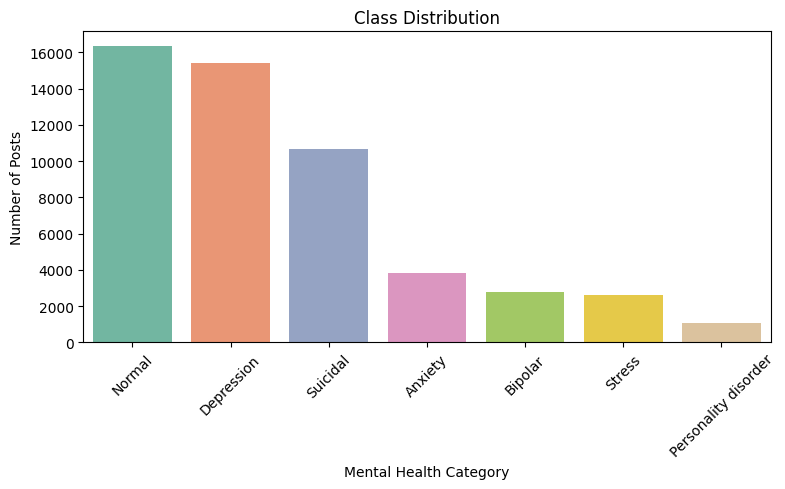

In [15]:
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='status', order=data['status'].value_counts().index, palette='Set2')
plt.title("Class Distribution")
plt.xlabel("Mental Health Category")
plt.ylabel("Number of Posts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
# Adding column for post lengths
data['text_length'] = data['statement'].astype(str).apply(len)

# Summary statistics
print("\nPost Length Stats:")
print(data['text_length'].describe())


Post Length Stats:
count    52680.000000
mean       579.421982
std        835.701200
min          2.000000
25%         80.000000
50%        317.000000
75%        755.000000
max      27588.000000
Name: text_length, dtype: float64


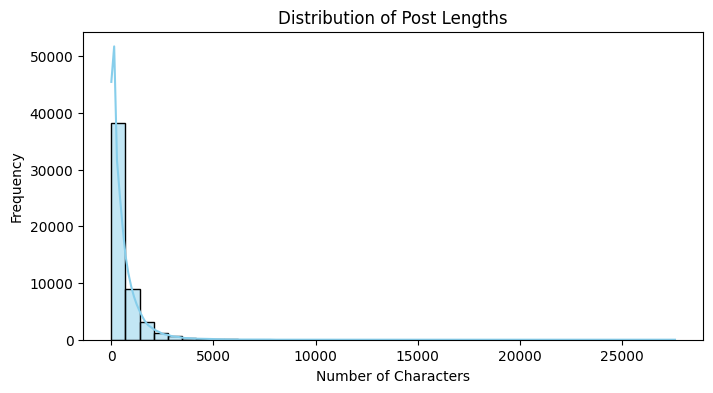

In [17]:
# Distribution plot
plt.figure(figsize=(8, 4))
sns.histplot(data['text_length'], bins=40, kde=True, color='skyblue')
plt.title("Distribution of Post Lengths")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.show()

#### **Word Cloud**

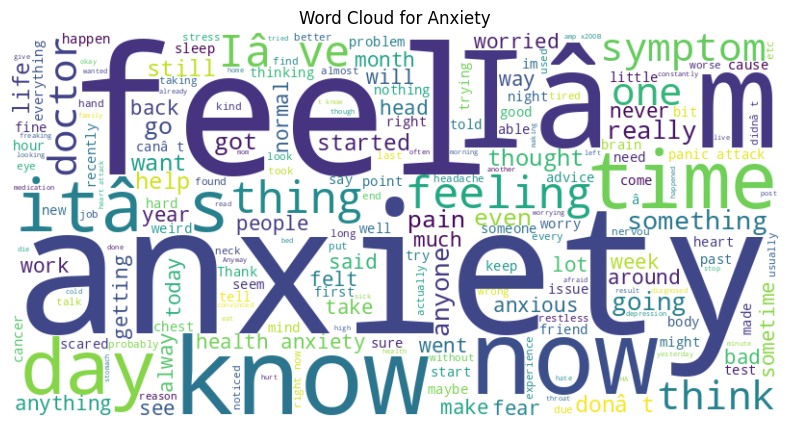

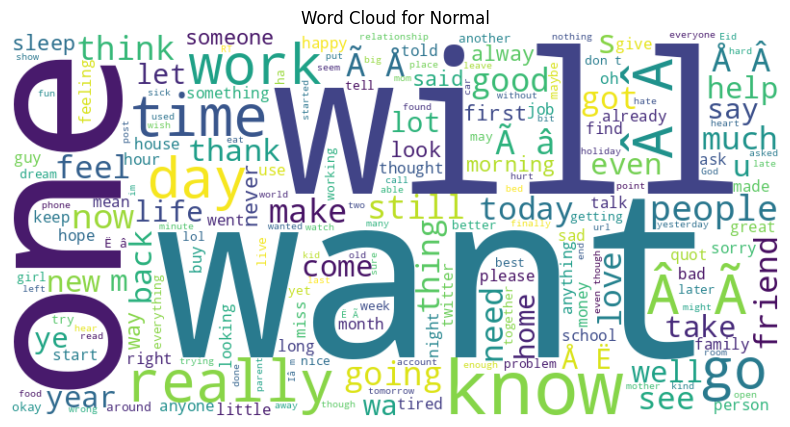

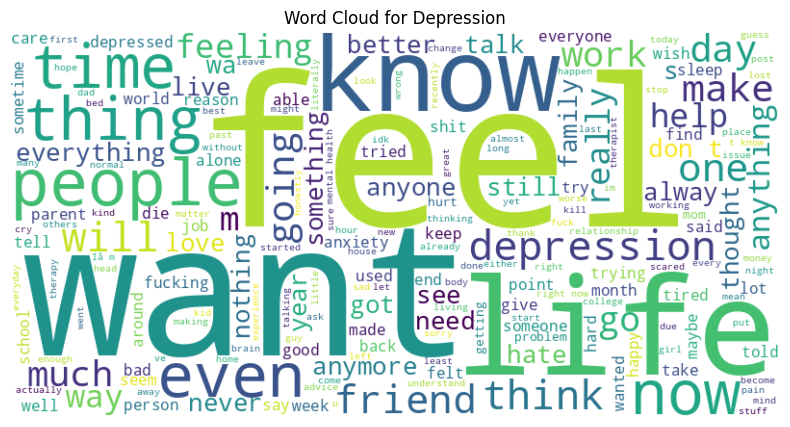

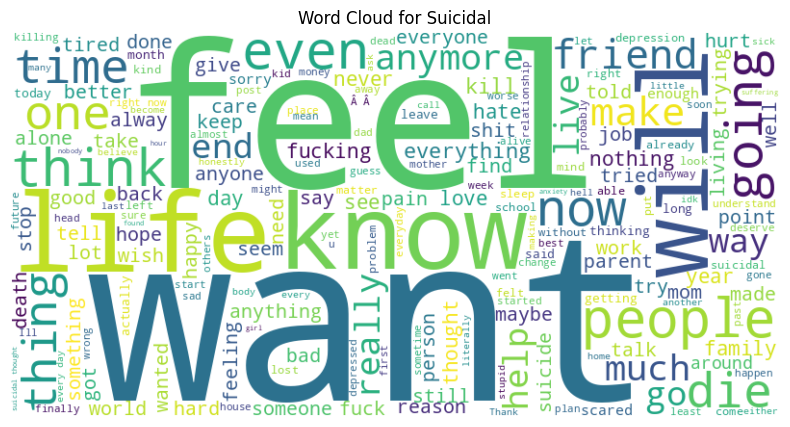

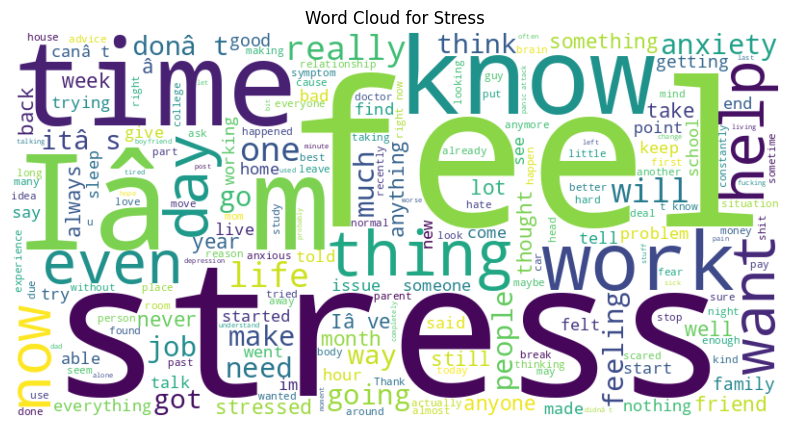

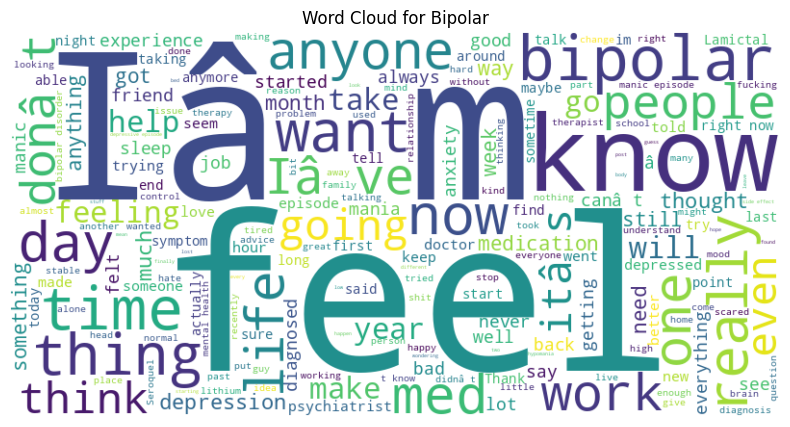

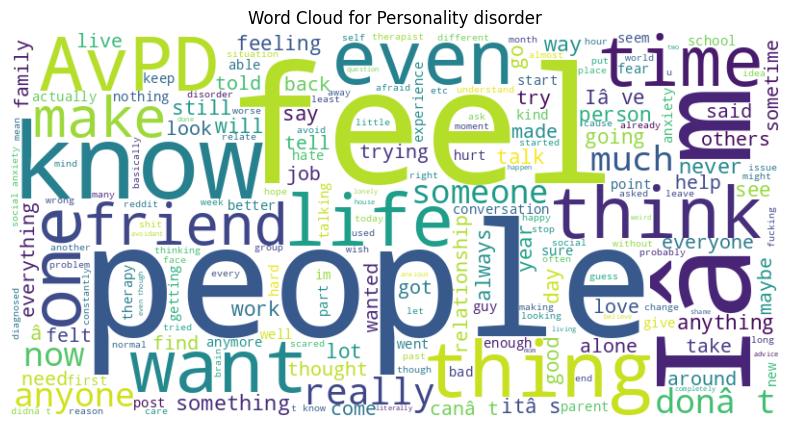

In [21]:
from wordcloud import WordCloud

# Combine text by label
for label in data['status'].unique():
    text = " ".join(data[data['status'] == label]['statement'].dropna().astype(str).tolist())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {label}")
    plt.show()

In [23]:
print(f"Total Posts: {len(data)}")
print(f"Unique Labels: {data['status'].nunique()}")
print("Top 5 most frequent labels:\n", data['status'].value_counts().head())

Total Posts: 52680
Unique Labels: 7
Top 5 most frequent labels:
 status
Normal        16343
Depression    15404
Suicidal      10651
Anxiety        3841
Bipolar        2777
Name: count, dtype: int64


## **Text Cleaning and Pre Processing**

In [24]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [25]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()
                     if word not in stop_words])
    return text

In [26]:
data['clean_text'] = data['statement'].apply(clean_text)

In [27]:
data[['statement', 'clean_text']].sample(5)

,statement,clean_text
30341,do you want to do something tomorrow?,want something tomorrow
3799,Anyone want to see a funny video or not? Just ...,anyone want see funny video dm ill send
44766,why doe it take so long to go through one lect...,doe take long go one lecture took min give sun...
19746,I cannot do it anymore. My mom died of drug ad...,cannot anymore mom died drug addiction grandmo...
33846,you can't believe what you hear on tv or radio.,cant believe hear tv radio


### **Handling Imbalanced Data**

In [28]:
from sklearn.preprocessing import LabelEncoder

# Encoding target labels into integers
le = LabelEncoder()
data['label_encoded'] = le.fit_transform(data['status'])

# Mapping for decoding later
label_map = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping:\n", label_map)

Label Mapping:
 {'Anxiety': np.int64(0), 'Bipolar': np.int64(1), 'Depression': np.int64(2), 'Normal': np.int64(3), 'Personality disorder': np.int64(4), 'Stress': np.int64(5), 'Suicidal': np.int64(6)}


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Converting cleaned text to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(data['clean_text'])
y = data['label_encoded']

In [30]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [31]:
# New class balance
from collections import Counter

print("Resampled class distribution:", Counter(y_resampled))

Resampled class distribution: Counter({0: 16343, 3: 16343, 2: 16343, 6: 16343, 5: 16343, 1: 16343, 4: 16343})


### **Sentiment Scoring using VADER**

In [32]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.1 MB/s eta 0:00:00


In [33]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [35]:
analyzer = SentimentIntensityAnalyzer()

# Function to get compound score
def get_sentiment(text):
    score = analyzer.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

data['vader_sentiment'] = data['clean_text'].apply(get_sentiment)
data[['statement', 'vader_sentiment']].head()

,statement,vader_sentiment
0,oh my gosh,Neutral
1,"trouble sleeping, confused mind, restless hear...",Negative
2,"All wrong, back off dear, forward doubt. Stay ...",Negative
3,I've shifted my focus to something else but I'...,Negative
4,"I'm restless and restless, it's been a month n...",Negative


/tmp/ipython-input-36-3009937867.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='vader_sentiment', data=data, palette='Set2')


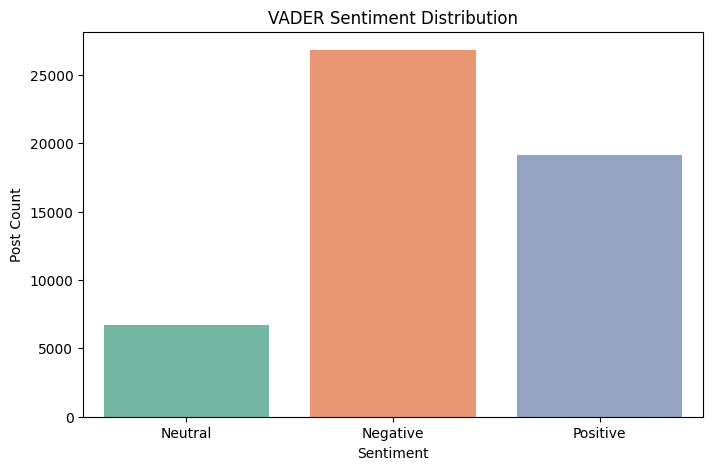

In [36]:
plt.figure(figsize=(8,5))
sns.countplot(x='vader_sentiment', data=data, palette='Set2')
plt.title("VADER Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Post Count")
plt.show()

### **Machine Learning Models**

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)


### **Logistic Regression**

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
print("Logistic Regression Report:\n")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_))

Logistic Regression Report:

                      precision    recall  f1-score   support

             Anxiety       0.90      0.83      0.86      3268
             Bipolar       0.96      0.95      0.96      3268
          Depression       0.75      0.62      0.68      3269
              Normal       0.69      0.81      0.74      3269
Personality disorder       0.95      0.99      0.97      3269
              Stress       0.78      0.78      0.78      3269
            Suicidal       0.69      0.71      0.70      3269

            accuracy                           0.81     22881
           macro avg       0.82      0.81      0.81     22881
        weighted avg       0.82      0.81      0.81     22881



In [42]:
accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 81.37%


#### **Confusion Matrix**

<Figure size 600x500 with 0 Axes>

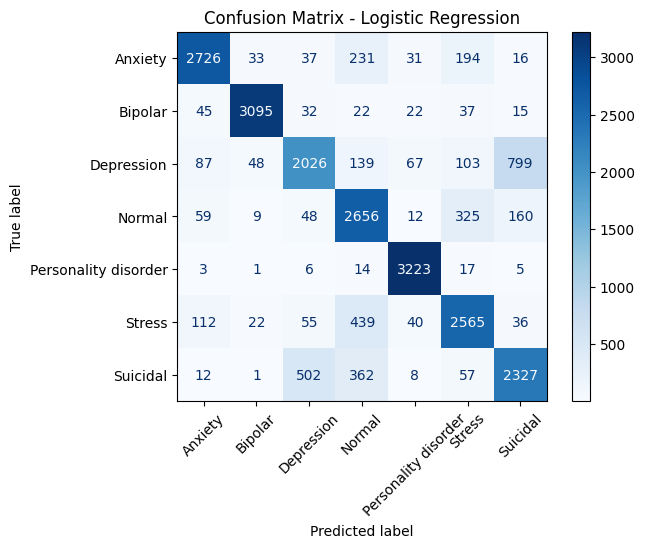

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=le.classes_)

plt.figure(figsize=(6,5))
disp_lr.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

### **Random Forest**

In [44]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print("Random Forest Report:\n")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

Random Forest Report:

                      precision    recall  f1-score   support

             Anxiety       0.93      0.76      0.83      3268
             Bipolar       0.97      0.94      0.95      3268
          Depression       0.76      0.51      0.61      3269
              Normal       0.57      0.96      0.72      3269
Personality disorder       0.98      0.94      0.96      3269
              Stress       0.86      0.83      0.84      3269
            Suicidal       0.70      0.67      0.68      3269

            accuracy                           0.80     22881
           macro avg       0.82      0.80      0.80     22881
        weighted avg       0.82      0.80      0.80     22881



In [45]:
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 79.99%


<Figure size 600x500 with 0 Axes>

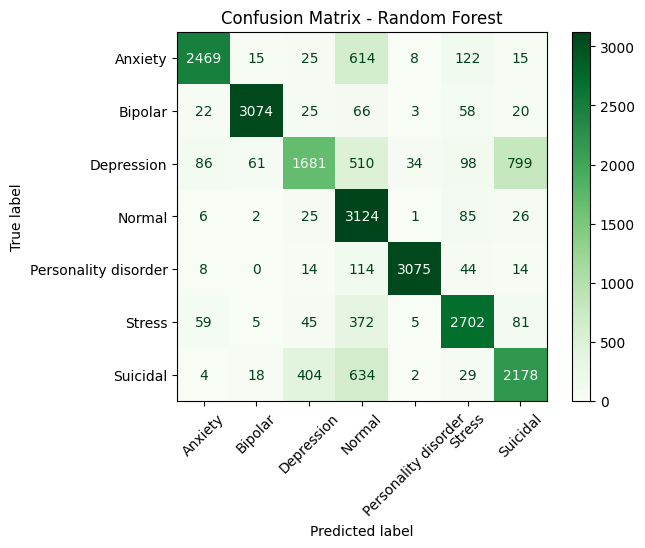

In [48]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=le.classes_)

plt.figure(figsize=(6,5))
disp_rf.plot(cmap='Greens', xticks_rotation=45)
plt.title("Confusion Matrix - Random Forest")
plt.show()

### **SHAP**

In [52]:
!pip install shap

In [53]:
import shap

X_sample = X_test[:100]
X_dense = X_sample.toarray()

explainer = shap.LinearExplainer(lr, X_train[:100].toarray(), feature_perturbation="interventional")
shap_values = explainer.shap_values(X_dense)

/usr/local/lib/python3.11/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


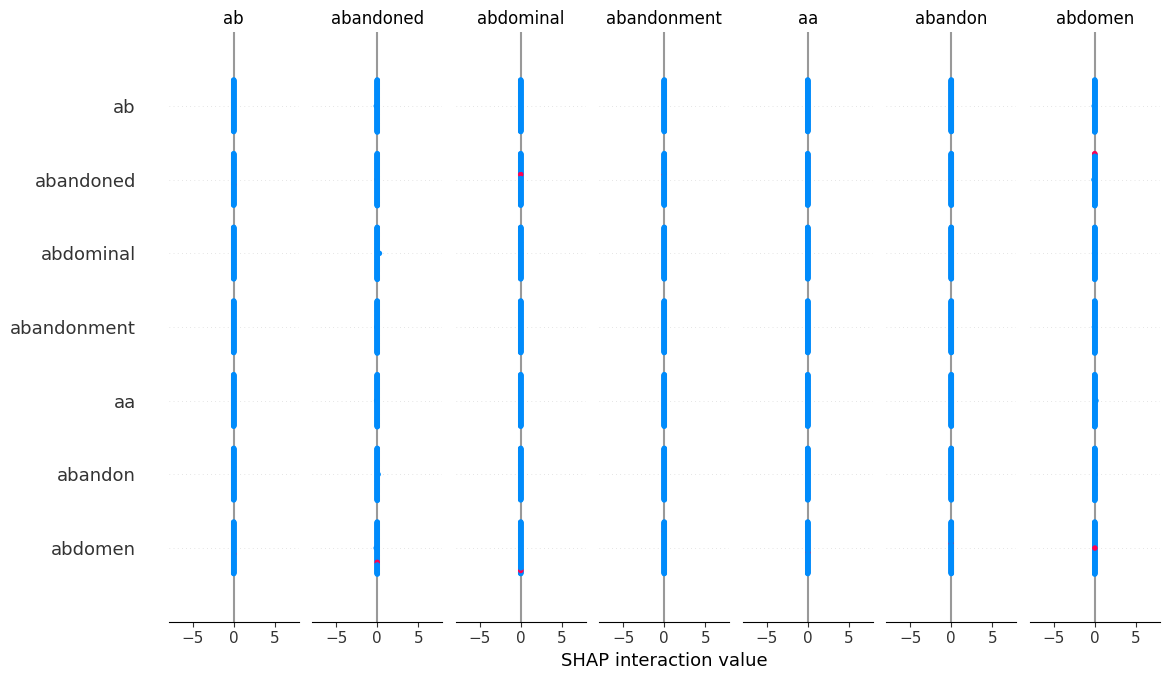

In [54]:
feature_names = vectorizer.get_feature_names_out()
shap.summary_plot(shap_values, X_dense, feature_names=feature_names)

### **Recommendation Engine**

In [55]:
def get_recommendation(label, sentiment):
    recs = []

    if label in ['Depression', 'Suicidal', 'Anxiety', 'Bipolar'] or sentiment == 'Negative':
        recs.append("National Mental Health Helpline (Pakistan): 1166")
        recs.append("BetterHelp: https://www.betterhelp.com/")
        recs.append("Read: 7 Coping Techniques for Anxiety & Depression")
        recs.append("Try: Guided Meditation (Headspace or Calm App)")
        if label == "Suicidal":
            recs.append("Urgent Help: Suicide Prevention Helpline (Umang: 0304-1112109)")
    else:
        recs.append("You seem emotionally stable. Keep journaling and practicing self-care.")
        recs.append("Explore daily wellness: https://www.mind.org.uk/information-support/tips-for-everyday-living/")

    return recs

In [57]:
example_row = data.iloc[100]

recommendations = get_recommendation(example_row['status'], example_row['vader_sentiment'])

print("Personalized Recommendations:")
for r in recommendations:
    print("-", r)

Personalized Recommendations:
- National Mental Health Helpline (Pakistan): 1166
- BetterHelp: https://www.betterhelp.com/
- Read: 7 Coping Techniques for Anxiety & Depression
- Try: Guided Meditation (Headspace or Calm App)


### **Streamlit App**

In [71]:
import joblib

joblib.dump(vectorizer, "vectorizer.pkl")
joblib.dump(lr, "logistic_model.pkl")
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']

In [77]:
!pip install streamlit pyngrok joblib --quiet

In [114]:
code = '''
import streamlit as st
import joblib

# Load model components
vectorizer = joblib.load("vectorizer.pkl")
model = joblib.load("logistic_model.pkl")  # or "random_forest_model.pkl"
label_encoder = joblib.load("label_encoder.pkl")

st.set_page_config(
    page_title="Mental Health Analyzer",
    layout="centered",
    initial_sidebar_state="collapsed"
)

st.markdown("""
<style>
    .main {
        max-width: 600px;
        padding: 20px;
        margin: auto;
    }
    .stTextArea textarea {
        min-height: 150px;
    }
    .result-box {
        border-radius: 10px;
        padding: 20px;
        margin-top: 20px;
        border-left: 5px solid;
        font-size: 16px;
    }
    .concern {
        background-color: #FFF4F4;
        border-color: #FF4B4B;
    }
    .neutral {
        background-color: #F0F8FF;
        border-color: #1DA1F2;
    }
    .resource-card {
        background: #fff;
        border-radius: 8px;
        padding: 14px;
        margin: 12px 0;
        box-shadow: 0 2px 6px rgba(0,0,0,0.06);
    }
    a {
        color: #1DA1F2;
        text-decoration: none;
    }
</style>
""", unsafe_allow_html=True)

st.title("Mental Health Sentiment Analyzer")
st.caption("Analyze social media posts to identify potential mental health concerns.")

user_input = st.text_area(
    "Paste a social media post for analysis:",
    placeholder="e.g. I feel like I'm drowning and nobody notices..."
)

if st.button("Analyze Post"):
    if not user_input.strip():
        st.warning("Please enter some text first.")
    else:
        X = vectorizer.transform([user_input])
        pred = model.predict(X)
        label = label_encoder.inverse_transform(pred)[0].lower()

        st.markdown("---")

        if label in ["depression", "suicidal", "anxiety", "bipolar"]:
            st.markdown(f"""
<div class='result-box concern'>
    <h4>Prediction: <u>{label.capitalize()}</u></h4>
    <p>This post may indicate signs of <b>{label}</b>. Consider seeking help.</p>
</div>
""", unsafe_allow_html=True)

            st.markdown("### Support Resources")
            st.markdown("""
<div class='resource-card'>
    <b>Talk to a Professional:</b>
    <a href='https://www.betterhelp.com/' target='_blank'>BetterHelp</a>
</div>
<div class='resource-card'>
    <b>Crisis Support:</b>
    <a href='https://unitedgmh.org/support/' target='_blank'>Checkpoint - Global Helplines</a>
</div>
<div class='resource-card'>
    <b>Self-Help Materials:</b>
    <a href='https://www.mentalhealth.org.uk/' target='_blank'>Mental Health Foundation</a>
</div>
""", unsafe_allow_html=True)
        else:
            st.markdown(f"""
<div class='result-box neutral'>
    <h4>Prediction: <u>{label.capitalize()}</u></h4>
    <p>No significant mental health concerns were detected in this post.</p>
</div>
""", unsafe_allow_html=True)

        st.markdown("---")
        st.button("Analyze Another", on_click=st.rerun)
'''

# Saving to file
with open("/content/app.py", "w") as f:
    f.write(code)

print("app.py created successfully.")


app.py created successfully.


In [117]:
from pyngrok import ngrok
import os

ngrok.set_auth_token("2w3AgeUvnrQQ7UWh2xVbIg8litV_7NoZYCVA9sC7qSUyfddaP")

# Kill any previous tunnels
ngrok.kill()

# Running streamlit app in background
os.system("streamlit run app.py &")

# Creating a public tunnel
public_url = ngrok.connect(8501, "http")
print("Public URL:", public_url)

Public URL: NgrokTunnel: "https://2842d0210576.ngrok-free.app" -> "http://localhost:8501"
